# CLIP

---

CLIP (Contrastive Language-Image Pre-training) は2021年にOpenAIが発表した視覚言語モデル（VLM）です．
CLIPでは，「画像から特徴量を抽出する画像エンコーダ」と「テキストから特徴量を抽出するテキストエンコーダ」を用意し，各エンコーダ出力の類似度を用いて画像とテキストの対応関係を対照学習により学習します．学習後のCLIPモデルは，画像とテキストの関連性が高いほど，画像・テキスト間の特徴量の類似度が高くなることから，任意の画像と"a photo of a クラス名."のようなクラス名を含んだテキストとの類似度から追加の学習なく画像のクラス分類（ゼロショットクラス分類）が可能です．

# CLIPによる画像のゼロショットクラス分類

本ノートブックでは，OpenAIが公開している学習済みのCLIPモデルを用いて，画像のゼロショットクラス分類を行います．

プログラムの構成は以下の通りです．
1. CLIPの学習済みモデルの用意\
・学習済みのCLIPモデル（画像エンコーダと言語エンコーダ）を用意します
2. データセットの用意\
・クラス分類を行いたいデータセットを用意します
3. 画像のゼロショットクラス分類\
・CLIPモデルを用いてゼロショットで（追加の学習をせずに）クラス分類を行います
4. UMAPによる特徴ベクトルの可視化\
・ゼロショットクラス分類がなぜ可能なのかを特徴ベクトルの可視化から確認します

## ライブラリのインポート

まず，OpenAIの学習済みCLIPモデルを呼び出すことができるように，openai/CLIPリポジトリをインストールします．\
CLIPリポジトリの詳細は以下のURLから確認することができます．
* openai/CLIP：https://github.com/openai/CLIP


In [1]:
!pip install git+https://github.com/openai/CLIP.git > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-i45jac23


本ノートブックで使用するライブラリをインポートします．

In [2]:
import os
import umap
import numpy as np
import torch
import torchvision
import clip
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
from tqdm import tqdm

## CLIPの学習済みモデルの用意
OpenAIの学習済みCLIPモデルは，先ほどインストールしたCLIPリポジトリから呼び出すことができ，\
画像エンコーダが異なる複数のCLIPモデルが用意されています．\
呼び出すことができる画像エンコーダの種類を以下に示します．
* CNN: RN50, RN101, RN50x4, RN50x16, RN50x64
* ViT: ViT-B/32, ViT-B/16, ViT-L/14, ViT-L/14@336px

In [3]:
# CLIPによる学習済みモデルの呼び出し
# model      : 画像エンコーダと言語エンコーダで構成されたモデル
# preprocess : 呼び出した学習済みモデルに対応した入力画像サイズと正規化が設定されたデータ拡張
model, preprocess = clip.load('ViT-B/16', "cpu")

# 学習済みモデルをGPUへ
model = model.cuda()

# 入力画像サイズと正規化の確認
print(preprocess)

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7b28089ef1a0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


話は脱線しますが，OpenAIが公開しているCLIPリポジトリには，学習プログラムが含まれていません．\
そのため，CLIPの学習を行いたい場合は，有志の方が作成したOpenCLIPリポジトリがよく使用されます．\
CLIPの学習プログラムに興味がある方は，ぜひOpenCLIPリポジトリをご確認ください．
* OpenCLIP：https://github.com/mlfoundations/open_clip

## データセットの用意
今回はデータセットとして，一般物体認識用データセットであるCIFAR-10を用います．\
CIFAR-10は，10クラス（飛行機，自動車，鳥，猫，鹿，犬，カエル，馬，船，トラック）の画像から構成されるデータセットです．\
ゼロショットクラス分類では，モデルの学習を行わないため，テスト用データのみを用意します．

In [4]:
# データセットの用意（テスト用データ）
testset = torchvision.datasets.CIFAR10(root="./dataset/CIFAR10", train=False, download=True, transform=preprocess)
test_loader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=16, pin_memory=True, drop_last=False)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 画像のゼロショットクラス分類
CLIPにおける画像のゼロショットクラス分類は，

1. クラス名を組み込んだプロンプトを用意
2. 予測したい画像とプロンプト間の類似度を計算
3. 最も類似度が高いプロンプトに組み込まれたクラスと判定

の3ステップの処理により，クラスを予測します．

### プロンプトの用意
CLIPでは，以下のようなテンプレートにクラス名を当てはめること，プロンプトを作成します．

* a photo of a クラス名.
* a blurry photo of a クラス名.
* a black and white photo of a クラス名.
* a low contrast photo of a クラス名.
* a high contrast photo of a クラス名.
* a bad photo of a クラス名.
* a good photo of a クラス名.

テンプレートは，画像やクラスの構成に合わせて用意します．\
CLIPの論文内では，

* 犬種・猫種分類において「a photo of a クラス名, a type of pet.」
* 標識だけが写った画像で構成された標識分類において「a zoomed in photo of a クラス名 traffic sign.」

が使用されました．\
CLIPで使用されたプロンプトのテンプレートは，以下から確認することができます．
* https://github.com/openai/CLIP/blob/main/data/prompts.md

今回は，「a photo of a クラス名.」を使用します．

In [5]:
# 各クラスのプロンプトを用意
text_list = [
    'a photo of a airplane',
    'a photo of a automobile',
    'a photo of a bird',
    'a photo of a cat',
    'a photo of a deer',
    'a photo of a dog',
    'a photo of a frog',
    'a photo of a horse',
    'a photo of a ship',
    'a photo of a truck',
]

# プロンプトをトークナイザーに適用
texts = torch.cat([clip.tokenize(text_i) for text_i in text_list])

# プロンプトをGPUへ
texts = texts.cuda()

### 分類したい画像の選択
分類したい画像を1つ選択し，可視化して画像を確認します．\
データセットから取り出した画像には，正規化が付与されています．\
そのため，画像を可視化する際には，正規化を打ち消して可視化します．

In [6]:
# 画像に対する正規化を打ち消す関数（画像の可視化のためにのみ使用）
def unnormalize_img(img, mean, std):
    """
    img : 正規化された画像
    mean: RGBの各チャネルの平均値
    std : RGBの各チャネルの標準偏差
    """
    # チャネルごとに正規化を打ち消し
    img = img.detach().clone()
    for i, m, s in zip(img, mean, std):
        i.mul_(s).add_(m)
    return img

In [7]:
# イテレータを作成し，データセットから1つのミニバッチを取得
tmp = test_loader.__iter__()
images, labels = next(tmp)

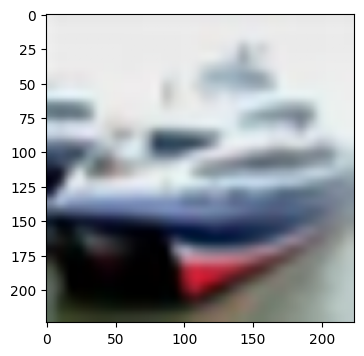

In [8]:
# 可視化したい画像のインデックス
show_id = 1

# 画像の可視化のために正規化を打ち消し
mean = (0.48145466, 0.4578275, 0.40821073)
std  = (0.26862954, 0.26130258, 0.27577711)
orig_img = unnormalize_img(images[show_id], mean, std)

# 画像の可視化
fig, ax = plt.subplots(ncols=1, figsize=(4,4))
ax.imshow(orig_img.permute(1,2,0))
fig.show()

### ゼロショットクラス分類
画像とプロンプト間の類似度に基づいてクラス分類を行います．

In [9]:
# モデルを評価用モードに変更
model.eval()

# torch.no_grad(): 勾配計算を無効化し，メモリ消費量を削減
# torch.cuda.amp.autocast(): Averaged Mixed Precision（AMP）による推論の高速化
with torch.no_grad(), torch.cuda.amp.autocast():
    # 画像をGPUへ
    images = images.cuda()

    # 画像とプロンプトの特徴抽出
    image_features = model.encode_image(images)
    text_features  = model.encode_text(texts)

    # 画像とプロンプト間のコサイン類似度を計算
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features  /= text_features.norm(dim=-1, keepdim=True)
    cos_sims = image_features @ text_features.T

    # 類似度にソフトマックス関数を適用（確率分布を作成）
    sim_probs = (100.0 * cos_sims).softmax(dim=-1)

/tmp/ipython-input-2597733305.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


計算したコサイン類似度を可視化します．

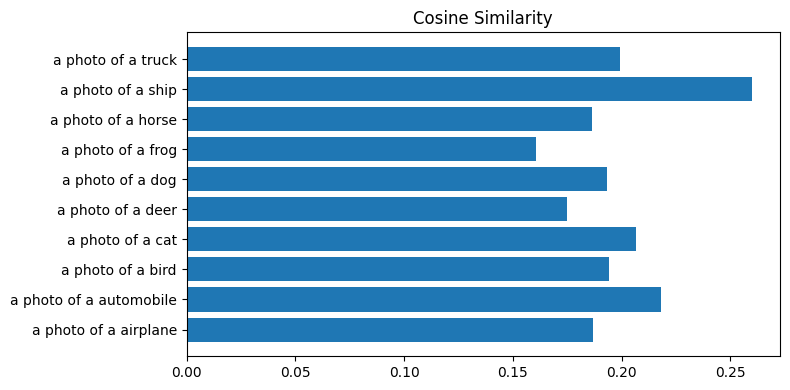

In [10]:
# 可視化した画像に対する類似度を取得
cos = cos_sims[show_id]

# 棒グラフとして可視化
plt.figure(figsize=(8, 4))
indices = np.arange(len(cos))
cos = cos.cpu().numpy()
plt.barh(indices, cos)
plt.yticks(indices, text_list)
plt.title('Cosine Similarity')
plt.tight_layout()
plt.show()

続いて，確率分布（ソフトマックス関数を適用したコサイン類似度）を可視化します．

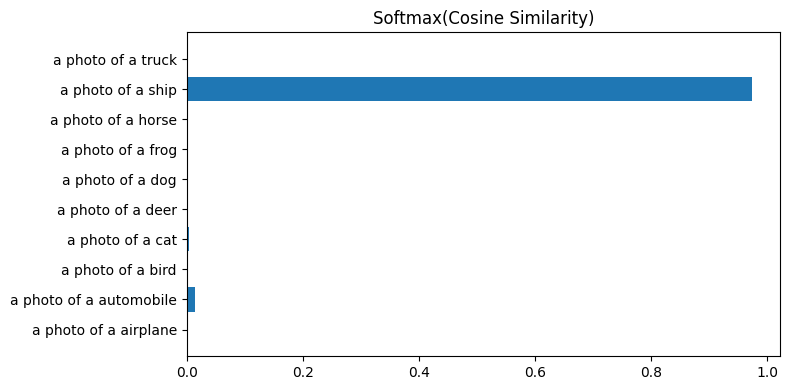

In [11]:
# 可視化した画像に対する確率分布を取得
probs = sim_probs[show_id]

# 棒グラフとして可視化
plt.figure(figsize=(8, 4))
indices = np.arange(len(probs))
probs = probs.cpu().numpy()
plt.barh(indices, probs)
plt.yticks(indices, text_list)
plt.title('Softmax(Cosine Similarity)')
plt.tight_layout()
plt.show()

### ゼロショットクラス分類による精度
先ほどはテストデータ内の1つのデータに対する分類結果を確認しました．\
続いて，テストデータ全体に対してゼロショットクラス分類を適用し，精度を確認します．


In [12]:
# ゼロショットクラス分類を行い精度を算出する関数
def zero_shot_classification(model, texts, data_loader):
    model.eval()  # モデルを評価用モードに変更
    correct_count = 0  # 正解したデータの数のカウント用

    with torch.no_grad(), torch.cuda.amp.autocast():
        # テキストの特徴抽出と特徴ベクトルの正規化
        text_features = model.encode_text(texts)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        for images, labels in tqdm(data_loader):  # tqdm: 進捗率をバーのアニメーションで表示
            # 画像と正解ラベルをGPUへ
            images = images.cuda()
            labels = labels.cuda()

            # 画像の特徴抽出と特徴ベクトルの正規化
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            # コサイン類似度を計算 -> softmax関数へ適用
            sim_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

            # 正解したデータ数をカウント
            pred = torch.argmax(sim_probs, dim=1)  # 一番確率値の高いクラスIDの取得（予測結果の取得）
            correct_count += torch.sum(pred == labels)  # 予測結果と正解ラベルのクラスIDが一致しているデータの数を加算

        # 精度の算出
        print("Acc. [%] : ", correct_count.item()/len(data_loader.dataset)*100)

In [13]:
zero_shot_classification(model, texts, test_loader)

/tmp/ipython-input-471653178.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
  0%|          | 0/625 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 625/625 [00:40<00:00, 15.53it/s]

Acc. [%] :  89.3


## UMAPによる特徴ベクトルの可視化
UMAPによって画像とプロンプトに対する特徴ベクトルを2次元に次元削減し，\
散布図によって可視化することで画像とプロンプトの関係を確認します．

### 特徴抽出とUMAPの適用

In [14]:
# 画像の特徴抽出とUMAPの適用を行う関数
def get_img_umap_feat(model, data_loader, feat_dim):
    model.eval()  # モデルを評価用モードに変更
    correct_count = 0  # 正解したデータの数のカウント用

    with torch.no_grad(), torch.cuda.amp.autocast():
        # 画像の特徴ベクトルと正解ラベルを格納するためのTensorの用意
        image_features = torch.zeros((len(data_loader.dataset), feat_dim))
        labels = torch.zeros(len(data_loader.dataset))

        # 特徴抽出済みの画像数のカウント
        cnt = 0

        # ミニバッチごとに特徴抽出
        for images, targets in tqdm(data_loader):
            # 画像数の取得
            batch_size = len(images)

            # 画像と正解ラベルをGPUへ
            images = images.cuda()

            # 画像の特徴抽出と特徴ベクトルの正規化
            output = model.encode_image(images)
            output /= output.norm(dim=-1, keepdim=True)

            # 画像の特徴ベクトルと正解ラベルを保存
            image_features[cnt:cnt+batch_size] = output.data.cpu()
            labels[cnt:cnt+batch_size] = targets.data.cpu()
            cnt += batch_size

        # UMAPによる特徴ベクトルの次元削減
        mapper = umap.UMAP(random_state=0)
        image_coords = mapper.fit_transform(image_features)
    return image_coords, labels, mapper

In [15]:
# プロンプトの特徴抽出と特徴ベクトルの正規化
text_features = model.encode_text(texts)
text_features /= text_features.norm(dim=-1, keepdim=True)

# 特徴ベクトルの次元数の取得
feat_dim = text_features.shape[1]

# 画像の特徴抽出とUMAPの適用
image_coords, labels, mapper = get_img_umap_feat(model, test_loader, feat_dim)

# UMAPによるプロンプト特徴ベクトルの次元削減
text_coords = mapper.transform(text_features.detach().cpu())

/tmp/ipython-input-1273764253.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
100%|██████████| 625/625 [00:33<00:00, 18.80it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### 次元削減した特徴ベクトルの可視化

In [16]:
def vis_2d_data_dist(image_coords, text_coords, labels, class_names, scale=1, save_dir=None):
    # Tensorをnumpy配列に変換
    labels = labels.cpu().numpy()

    # 散布図で使用する色情報
    mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # グラフの用意
    fig, ax = plt.subplots(figsize=(12*scale, 8*scale))
    fig.subplots_adjust(right=0.75)  # 凡例表示スペース確保

    # 画像特徴ベクトルの可視化
    for cls_idx, cls_name in enumerate(class_names):
        mask = (labels == cls_idx)
        if mask.any():
            ax.scatter(image_coords[mask, 0], image_coords[mask, 1], s=5.0, color=mpl_colors[cls_idx], label=cls_name, alpha=0.7, zorder=1)

    # プロンプト特徴ベクトルの可視化
    for cls_idx in range(len(class_names)):
        ax.scatter(text_coords[cls_idx, 0], text_coords[cls_idx, 1], s=100.0, marker="*", color=mpl_colors[cls_idx], edgecolors="k", linewidths=1.0, alpha=1.0, zorder=10)

    # 縦軸と横軸のラベル
    ax.set_xlabel('UMAP_1')
    ax.set_ylabel('UMAP_2')

    # 判例
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), borderaxespad=0., fontsize='small', markerscale=2)

    # グラフの保存
    if save_dir:
        plt.savefig(save_dir, bbox_inches='tight')

    # グラフの表示
    plt.show()

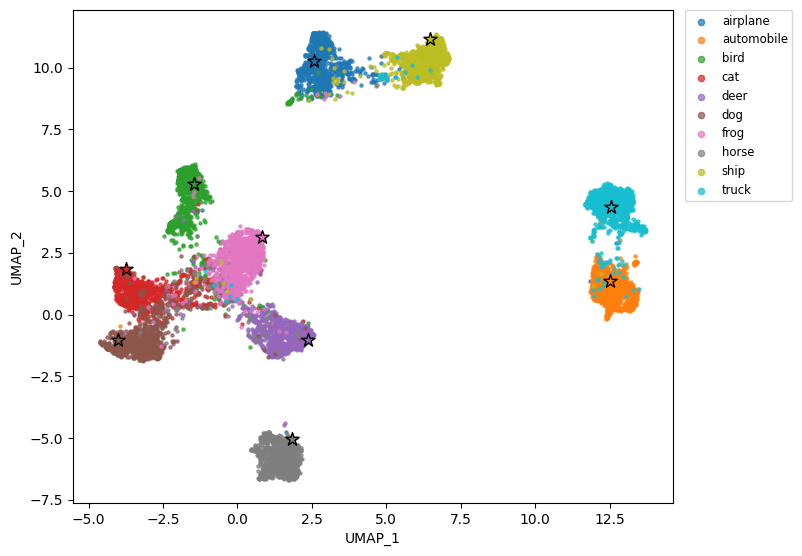

In [17]:
# 2次元ベクトルを散布図で可視化
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
vis_2d_data_dist(image_coords, text_coords, labels, classes, 0.8, '2d_feat.png')

# 課題
プロンプトを変更した場合に画像との類似度がどのように変化するか確認しよう
* 例：飛行機クラスの画像に対して「空を飛ぶ飛行機」や「地上の飛行機」など